In [ ]:
!pip install torchmetrics pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 53.6 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pytorch_lightning as pl
import torchvision.transforms as transform
from tqdm.notebook import tqdm
from torch import nn, optim
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import defaultdict, namedtuple
from torch.utils.data import DataLoader
%config InlineBackend.figure_format = 'retina'

In [ ]:
fashion_mnist_train = torchvision.datasets.FashionMNIST('./data', download = True, transform = transforms.Compose([transforms.ToTensor()]))
fashion_mnist_val = torchvision.datasets.FashionMNIST('./data',train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]), )

train_dataloader = DataLoader(fashion_mnist_train, batch_size = 40, shuffle = True, num_workers = 4, persistent_workers = True)
val_dataloader = DataLoader(fashion_mnist_val, batch_size = 40, num_workers = 4)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 163kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.17MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.5MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


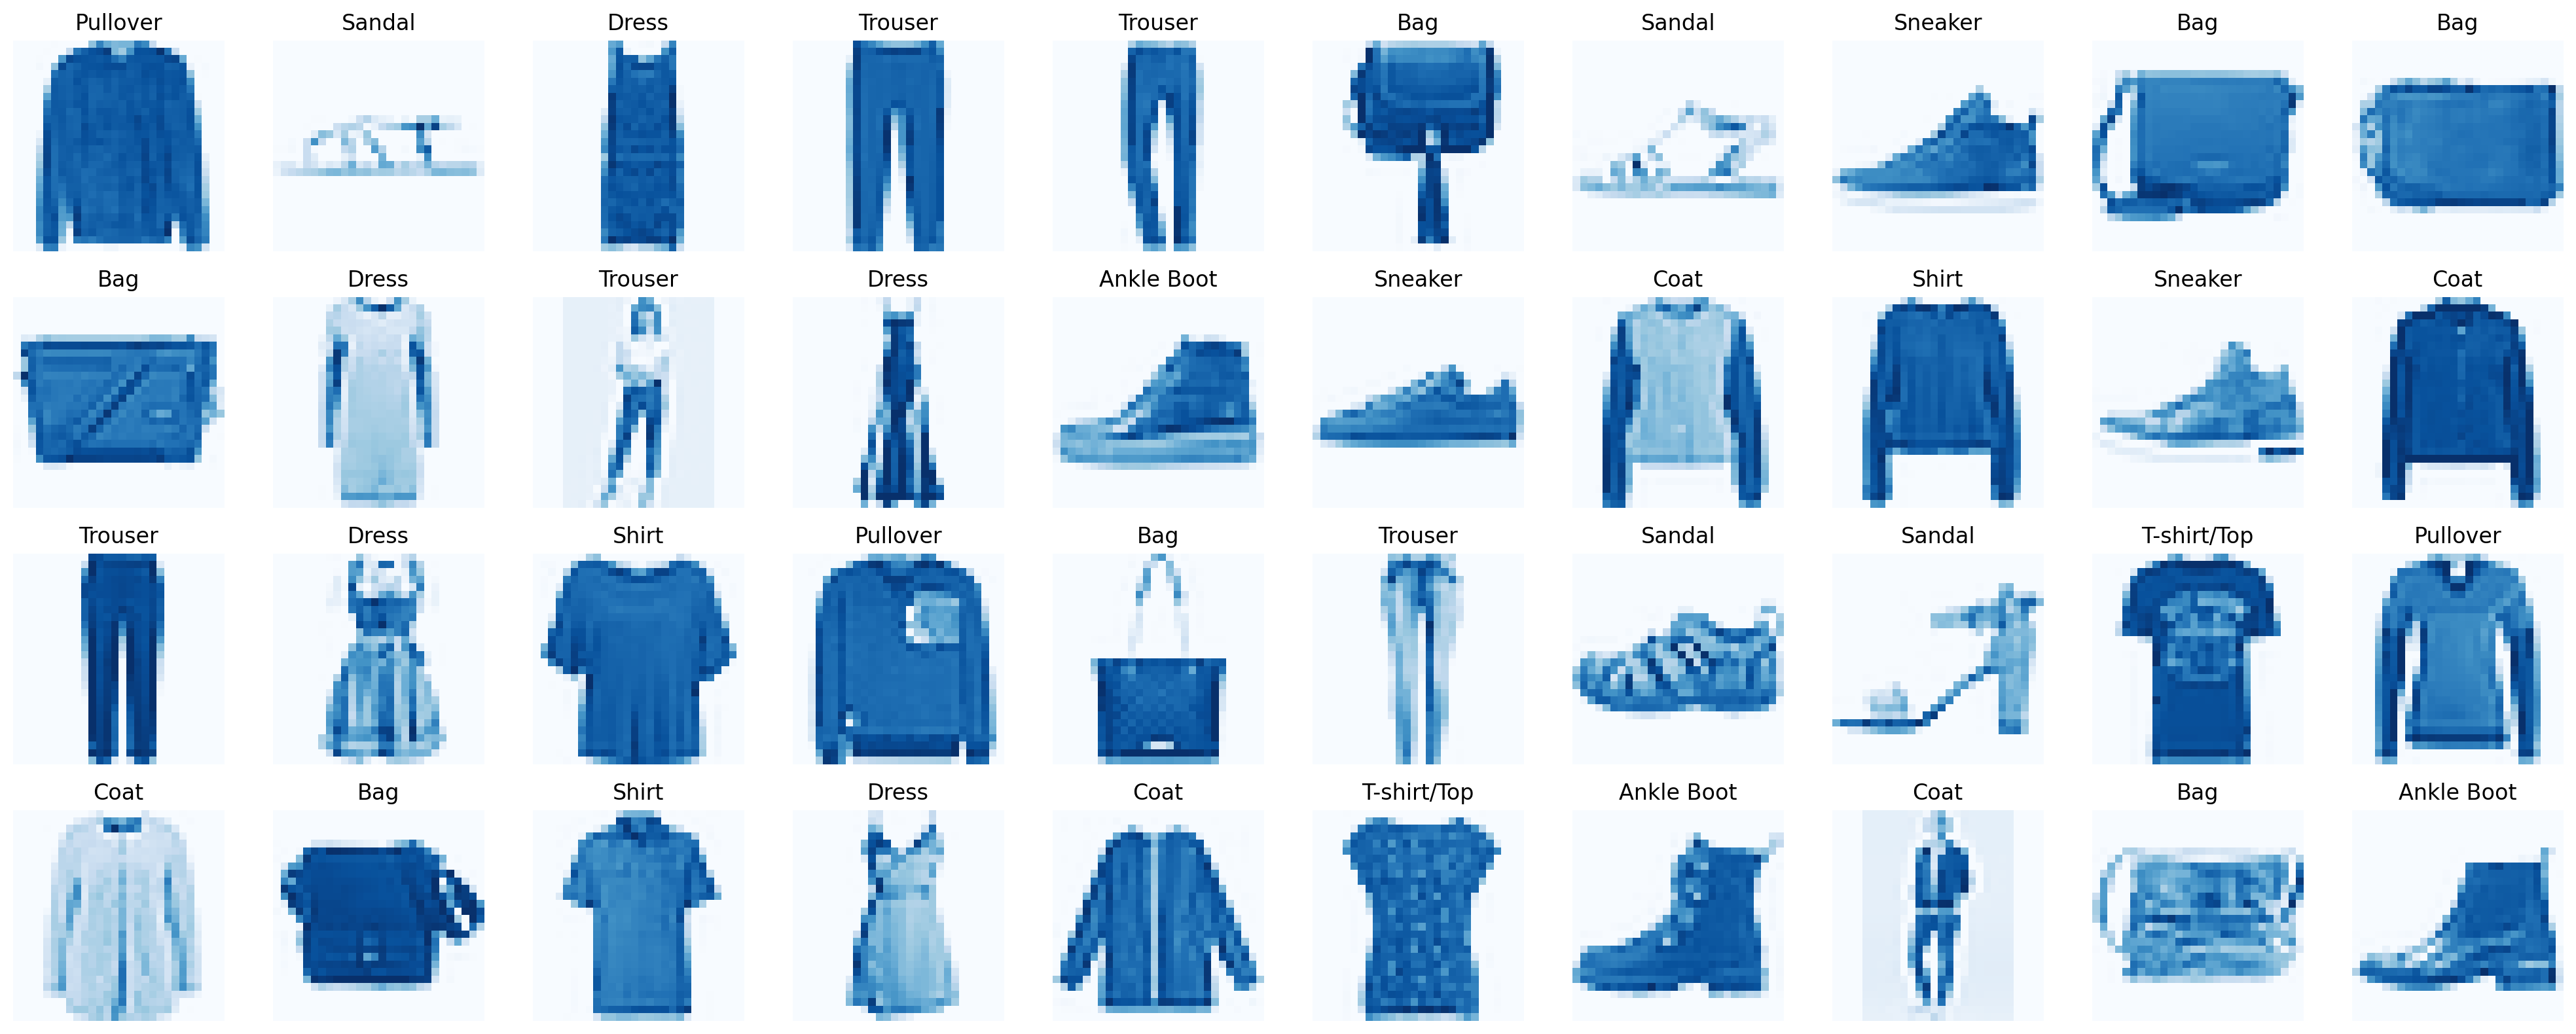

In [ ]:
images, labels = next(iter(train_dataloader))
fig, axes = plt.subplots(4, 10, figsize = (20, 8))

classes = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0)
    img = img.clamp(0, 1)
    ax.imshow(img, cmap = 'Blues')
    ax.set_title(classes[labels[i].item()])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class VGG_16(nn.Module):

    def __init__(self):
        super().__init__()

        self.vgg_block1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.vgg_block2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.vgg_block3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.vgg_block4 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.vgg_block5 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.fc_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features = 512 * 1 * 1, out_features = 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 4096, out_features = 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 4096, out_features = 10),
        )


    def forward(self, x):
        x = self.vgg_block1(x)
        x = self.vgg_block2(x)
        x = self.vgg_block3(x)
        x = self.vgg_block4(x)
        x = self.vgg_block5(x)
        x = self.fc_layers(x)
        return x

In [ ]:
class train(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()

        # метрики
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, target = batch
        outputs = self(images)
        loss = self.criterion(outputs, target)

        acc = self.train_acc(outputs, target)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, target = batch
        outputs = self(images)
        loss = self.criterion(outputs, target)

        # accuracy
        acc = self.val_acc(outputs, target)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [ ]:
device

device(type='cuda')

In [ ]:
VGG16 = VGG_16().to(device)

In [ ]:
module = train(VGG16, learning_rate = 0.001)

In [ ]:
trainer = pl.Trainer(accelerator = 'cuda', max_epochs = 10)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | VGG_16             | 33.6 M | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
33.6 M    Trainable params
0         Non-trainable params
33.6 M    Total params
134.582   Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


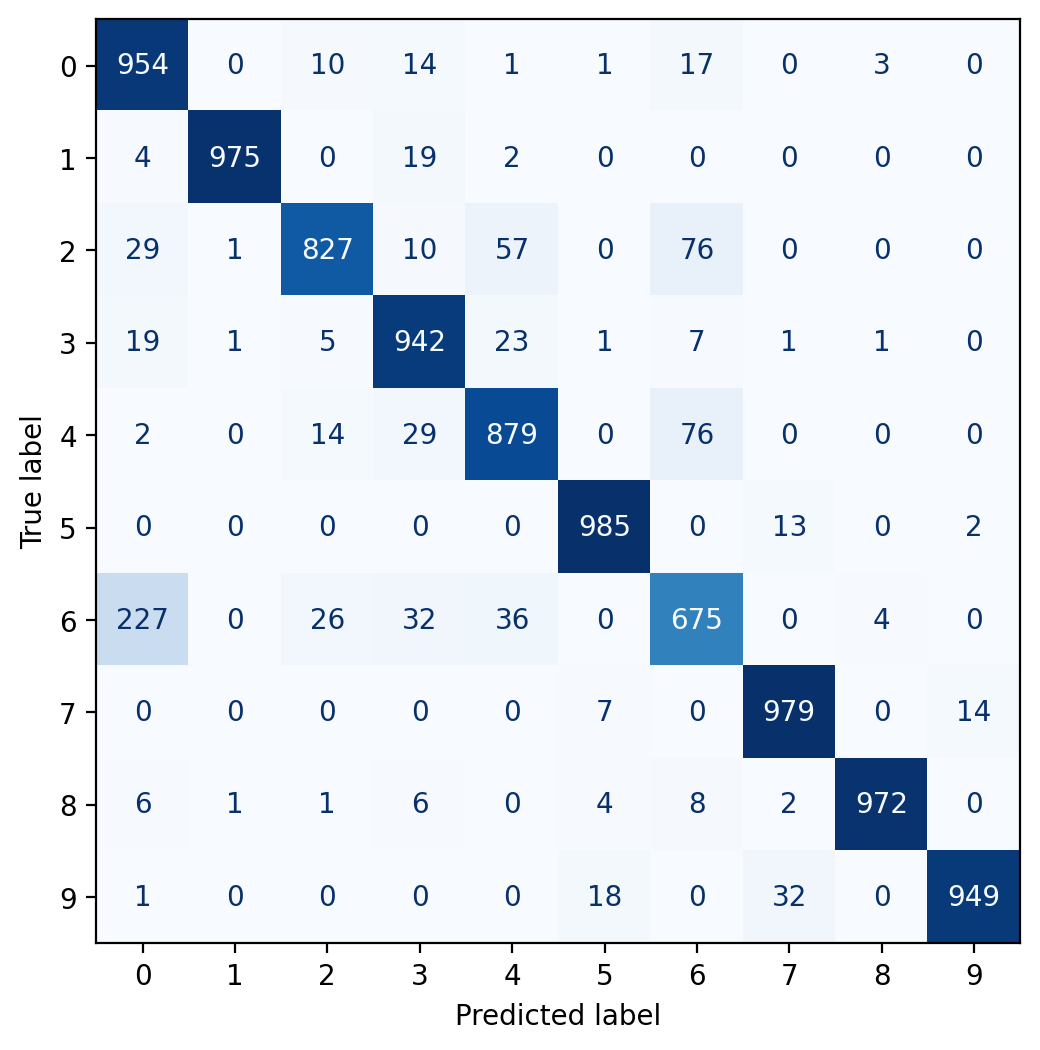

In [ ]:
VGG16.to(device)
VGG16.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x_val, y_val in val_dataloader:
        x_val, y_val = x_val.to(device), y_val.to(device)
        y_pred = VGG16(x_val)
        preds = torch.argmax(y_pred, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

fig, ax = plt.subplots(figsize = (6,6))
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, cmap = plt.cm.Blues, ax = ax, colorbar = False)
plt.show()

In [ ]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1000
           1       1.00      0.97      0.99      1000
           2       0.94      0.83      0.88      1000
           3       0.90      0.94      0.92      1000
           4       0.88      0.88      0.88      1000
           5       0.97      0.98      0.98      1000
           6       0.79      0.68      0.73      1000
           7       0.95      0.98      0.97      1000
           8       0.99      0.97      0.98      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



In [ ]:
def show_errors(model, dataloader, device, n_images = 24, cols = 6):

    classes = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

    model.eval()
    images_shown = 0
    rows = int(np.ceil(n_images / cols))

    fig, axes = plt.subplots(rows, cols, figsize = (16, 8))

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            preds = torch.argmax(y_pred, dim = 1)

            for i in range(x_batch.size(0)):
                if images_shown >= n_images:
                    break
                if preds[i] != y_batch[i]:
                    ax = axes.flat[images_shown]
                    ax.imshow(x_batch[i][0].cpu(), cmap = 'Blues')
                    ax.set_title(f'Pred: {classes[preds[i].item()]}\nTrue: {classes[y_batch[i].item()]}')
                    ax.axis('off')
                    images_shown += 1
            if images_shown >= n_images:
                break

    plt.tight_layout()
    plt.show()

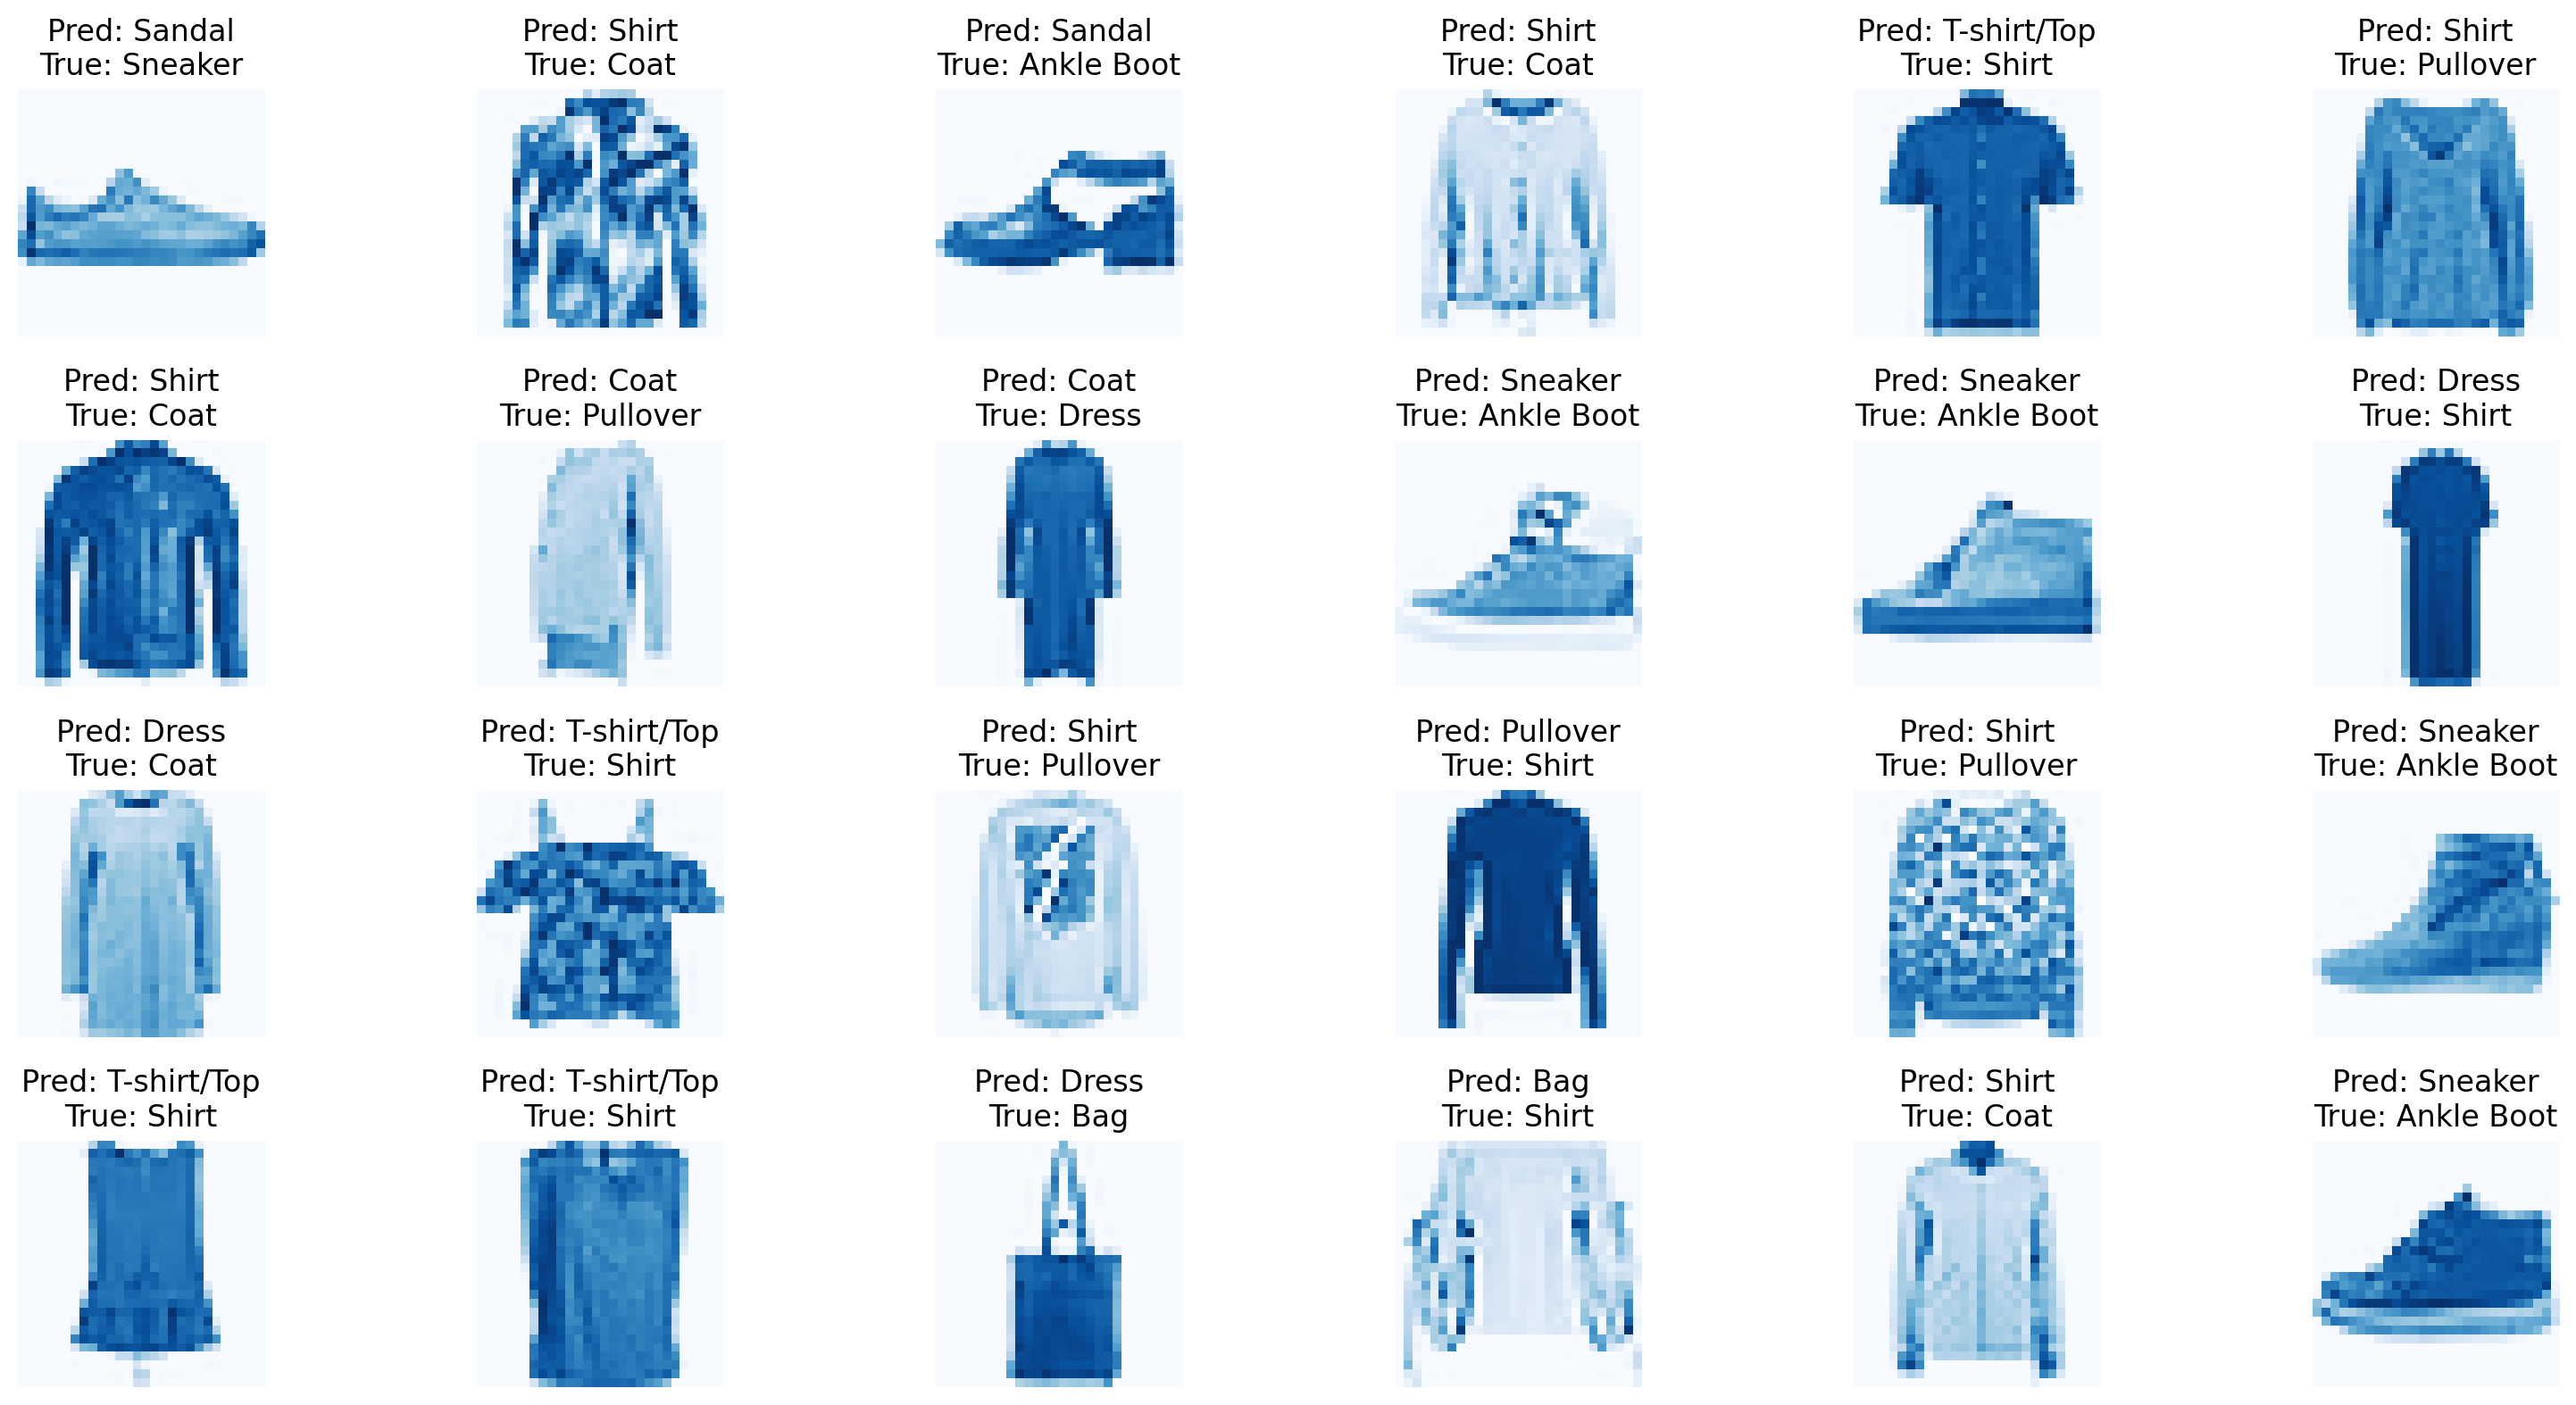

In [ ]:
show_errors(VGG16, val_dataloader, device, n_images = 24, cols = 6)